In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import random as rn
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 시드 설정
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# XGBoost 버전 확인
print(f"XGBoost 버전: {xgboost.__version__}")

print("🚀 전력 사용량 예측 앙상블 모델 시작!")
print("=" * 50)


XGBoost 버전: 1.6.1
🚀 전력 사용량 예측 앙상블 모델 시작!


In [2]:
def smape(gt, preds):
    """SMAPE (Symmetric Mean Absolute Percentage Error) 계산"""
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score
    
def weighted_mse(alpha=1):
    """가중 MSE 손실 함수 (Under-prediction에 더 큰 페널티)"""
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    """XGBoost용 SMAPE 평가 함수"""
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

print("✅ 평가 함수 정의 완료")


✅ 평가 함수 정의 완료


In [3]:
# 데이터 로드
print("📊 데이터 로드 중...")
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"✅ Train 데이터: {train.shape}")
print(f"✅ Test 데이터: {test.shape}")
print(f"✅ Building info: {building_info.shape}")

# 컬럼명 영어로 변경 (작년 수상자 방식)
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis=1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation'
})
test.drop('num_date_time', axis=1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

# 건물 유형 영어로 번역
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department Store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# 태양광/ESS 설비 유무 피처 생성
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity != '-', 1, 0)
building_info['ess_utility'] = np.where(building_info.ess_capacity != '-', 1, 0)

# 건물 정보 병합
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

print("✅ 기본 전처리 완료")


📊 데이터 로드 중...
✅ Train 데이터: (204000, 10)
✅ Test 데이터: (16800, 7)
✅ Building info: (100, 7)
✅ 기본 전처리 완료


In [4]:
# 날짜/시간 변환 및 기본 시간 피처 생성
print("🔧 Feature Engineering 시작...")

train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# 기본 시간 피처
for df in [train, test]:
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.dayofweek

print("✅ 기본 시간 피처 생성 완료")


🔧 Feature Engineering 시작...
✅ 기본 시간 피처 생성 완료


In [5]:
# 일별 온도 통계 피처 생성
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    """일별 통계값 계산 함수"""
    result_dict = {}
    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)
    
    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value
    
    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

# 일별 온도 통계 피처 생성
for df in [train, test]:
    calculate_day_values(df, 'temperature', 'day_max_temperature', 'max')
    calculate_day_values(df, 'temperature', 'day_mean_temperature', 'mean')
    calculate_day_values(df, 'temperature', 'day_min_temperature', 'min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']

print("✅ 일별 온도 통계 피처 생성 완료")


✅ 일별 온도 통계 피처 생성 완료


In [6]:
# 이상치 제거 및 추가 피처 생성
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print(f"제거할 이상치 개수: {len(outlier_idx)}")
train.drop(index=outlier_idx, inplace=True)
print(f"남은 행 개수: {train.shape[0]}")

# 공휴일 피처 생성
holi_weekday = ['2024-06-06', '2024-08-15']
train['holiday'] = np.where(
    (train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)
test['holiday'] = np.where(
    (test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)



# 주기성 피처 생성 (Cyclical Features)
for df in [train, test]:
    # 시간 주기성
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 23.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 23.0)
    
    # 날짜 주기성
    df['sin_date'] = -np.sin(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    df['cos_date'] = -np.cos(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    
    # 월 주기성
    df['sin_month'] = -np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = -np.cos(2 * np.pi * df['month'] / 12.0)
    
    # 요일 주기성
    df['sin_dayofweek'] = -np.sin(2 * np.pi * (df['day_of_week'] + 1) / 7.0)
    df['cos_dayofweek'] = -np.cos(2 * np.pi * (df['day_of_week'] + 1) / 7.0)

print("✅ 이상치 제거 및 주기성 피처 생성 완료")


제거할 이상치 개수: 68
남은 행 개수: 203932
✅ 이상치 제거 및 주기성 피처 생성 완료


In [7]:

def create_inferred_holidays(df, building_info):
    # 규칙이 없는 백화점 건물 번호 추출
    department_store_buildings = [19,34,45,54,73,74,79,88,95]

    # 백화점 건물에 대해 추정 휴일만 적용
    for building_num in department_store_buildings:
        building_data = df[df['building_number'] == building_num].copy()

        if len(building_data) > 0:
            # 일별 전력소비량 계산
            building_data['date'] = building_data['date_time'].dt.date
            daily_consumption = building_data.groupby('date')['power_consumption'].sum()

            # 전체 평균 기준 임계치 (0.7배)
            threshold = daily_consumption.mean() * 0.7
            inferred_holiday_dates = daily_consumption[daily_consumption < threshold].index

            # 추정 휴일을 해당 건물의 holiday 컬럼에 적용
            for holiday_date in inferred_holiday_dates:
                mask = (df['building_number'] == building_num) & (df['date_time'].dt.date == holiday_date)
                df.loc[mask, 'holiday'] = 1

    return df

# 휴일 피처 생성
train = create_inferred_holidays(train, building_info)

In [8]:
# 매주 일요일 휴무 건물(18번) 추가 및 기존 규칙 유지

def apply_specific_building_holidays(df):
    """
    특정 건물들의 휴일 규칙을 적용하는 함수 (달력 기준 주차 계산)
    - 18번 건물: 매주 일요일 휴무
    - 27, 40, 63번 건물: 홀수 주 일요일 휴무
    - 29번 건물: 매달 10일 + 5번째 주 일요일 휴무
    - 32번 건물: 홀수 주 월요일 휴무
    """
    print("🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)")
    department_store_buildings = building_info[building_info['building_type'] == 'Department Store']['building_number'].tolist()

    # 백화점 건물에 해당하는 데이터만 holiday를 0으로 초기화
    df.loc[df['building_number'].isin(department_store_buildings), 'holiday'] = 0

    # 매주 일요일 휴무 건물 (18번)
    every_sunday_buildings = [18]

    # 홀수 주 일요일 휴무 건물들 (27, 40, 59, 63)
    odd_week_sunday_buildings = [27, 40, 59, 63]

    # 매달 10일 + 5번째 주 일요일 휴무 건물 (29)
    special_holiday_building = [29]

    # 홀수 주 월요일 휴무 건물 (32)
    odd_week_monday_buildings = [32]

    # 달력 기준 주차 계산 (일요일 시작)
    def get_calendar_week_of_month(date_series):
        """달력 기준 주차 계산 (월의 첫날이 포함된 주를 1주차로)"""
        result = []
        for date in date_series:
            first_day = date.replace(day=1)
            first_day_weekday = first_day.weekday()
            days_to_week_start = (first_day_weekday + 1) % 7  # 일요일 기준
            week_start_of_first = first_day - pd.Timedelta(days=days_to_week_start)
            days_since_first_week_start = (date - week_start_of_first).days
            week_num = (days_since_first_week_start // 7) + 1
            result.append(week_num)
        return result

    # 달력 기준 주차 계산
    df['calendar_week_of_month'] = get_calendar_week_of_month(df['date_time'])

    # 0. 매주 일요일 휴무 (18번 건물)
    for building_num in every_sunday_buildings:
        mask = (df['building_number'] == building_num) & (df['day_of_week'] == 6)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 매주 일요일 휴일 {count}개 적용")

    # 1. 홀수 주 일요일 휴무 (27, 40, 59, 63번 건물)
    for building_num in odd_week_sunday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 6) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 일요일 휴일 {count}개 적용")

    # 2. 매달 10일 + 5번째 주 일요일 휴무 (29번 건물)
    for building_num in special_holiday_building:
        mask_10th = (df['building_number'] == building_num) & (df['date_time'].dt.day == 10)
        df.loc[mask_10th, 'holiday'] = 1
        count_10th = mask_10th.sum()
        mask_5th_sunday = (df['building_number'] == building_num) & \
                          (df['day_of_week'] == 6) & \
                          (df['calendar_week_of_month'] == 5)
        df.loc[mask_5th_sunday, 'holiday'] = 1
        count_5th_sunday = mask_5th_sunday.sum()
        print(f"   건물 {building_num}: 매달 10일 휴일 {count_10th}개, 5번째 주 일요일 {count_5th_sunday}개 적용")

    # 3. 홀수 주 월요일 휴무 (32번 건물)
    for building_num in odd_week_monday_buildings:
        mask = (df['building_number'] == building_num) & \
               (df['day_of_week'] == 0) & \
               (df['calendar_week_of_month'] % 2 == 1)
        df.loc[mask, 'holiday'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 홀수 주 월요일 휴일 {count}개 적용")

    # 임시 컬럼 제거
    df.drop(['calendar_week_of_month'], axis=1, inplace=True)

    return df

# test 데이터에 특정 건물 휴일 규칙 적용
test = apply_specific_building_holidays(test)

print("✅ test 데이터에 백화점 추정 휴일 적용 완료")
print("✅ test 데이터에 특정 건물 휴일 규칙 적용 완료")


🔧 특정 건물 휴일 규칙 적용 중... (달력 기준 주차)
   건물 18: 매주 일요일 휴일 24개 적용
   건물 27: 홀수 주 일요일 휴일 24개 적용
   건물 40: 홀수 주 일요일 휴일 24개 적용
   건물 59: 홀수 주 일요일 휴일 24개 적용
   건물 63: 홀수 주 일요일 휴일 24개 적용
   건물 29: 매달 10일 휴일 0개, 5번째 주 일요일 24개 적용
   건물 32: 홀수 주 월요일 휴일 24개 적용
✅ test 데이터에 백화점 추정 휴일 적용 완료
✅ test 데이터에 특정 건물 휴일 규칙 적용 완료


In [9]:
n  = 59
holiday_dates_n = test.loc[(test['building_number'] == n) & (test['holiday'] == 1), 'date_time'].dt.date
unique_holiday_dates_n = holiday_dates_n.drop_duplicates().tolist()
print(f"건물 {n}번 (홀수 주 월요일) 휴일: {len(unique_holiday_dates_n)}일")
print(f"날짜: {unique_holiday_dates_n[:10]}...")  # 처음 10개만 출력

건물 59번 (홀수 주 월요일) 휴일: 1일
날짜: [datetime.date(2024, 8, 25)]...


In [10]:

# 호텔 성수기 피처 생성 (8월을 성수기로 설정)
def create_hotel_peak_season(df, building_info):
    """
    호텔 건물에 대해 8월을 성수기로 설정하는 함수
    8월이면 1, 아니면 0
    """
    print("🏨 호텔 성수기 피처 생성 중...")
    
    # 호텔 건물 번호 추출
    hotel_buildings = building_info[building_info['building_type'] == 'Hotel']['building_number'].tolist()
    print(f"   호텔 건물 번호: {sorted(hotel_buildings)}")
    
    # 모든 건물에 대해 peak_season 컬럼을 0으로 초기화
    df['peak_season'] = 0
    
    # 호텔 건물에 대해서만 8월을 성수기(1)로 설정
    for building_num in hotel_buildings:
        mask = (df['building_number'] == building_num) & (df['month'] == 8)
        df.loc[mask, 'peak_season'] = 1
        count = mask.sum()
        print(f"   건물 {building_num}: 8월 성수기 {count}개 적용")
    
    total_peak_season = df['peak_season'].sum()
    print(f"   전체 성수기 데이터 포인트: {total_peak_season}개")
    
    return df

# 호텔 성수기 피처 적용
for df in [train, test]:
    df = create_hotel_peak_season(df, building_info)

print("✅ 호텔 성수기 피처 생성 완료")

🏨 호텔 성수기 피처 생성 중...
   호텔 건물 번호: [1, 4, 9, 10, 28, 77, 84, 89, 98, 100]
   건물 1: 8월 성수기 576개 적용
   건물 4: 8월 성수기 576개 적용
   건물 9: 8월 성수기 576개 적용
   건물 10: 8월 성수기 576개 적용
   건물 28: 8월 성수기 576개 적용
   건물 77: 8월 성수기 576개 적용
   건물 84: 8월 성수기 576개 적용
   건물 89: 8월 성수기 576개 적용
   건물 98: 8월 성수기 576개 적용
   건물 100: 8월 성수기 576개 적용
   전체 성수기 데이터 포인트: 5760개
🏨 호텔 성수기 피처 생성 중...
   호텔 건물 번호: [1, 4, 9, 10, 28, 77, 84, 89, 98, 100]
   건물 1: 8월 성수기 168개 적용
   건물 4: 8월 성수기 168개 적용
   건물 9: 8월 성수기 168개 적용
   건물 10: 8월 성수기 168개 적용
   건물 28: 8월 성수기 168개 적용
   건물 77: 8월 성수기 168개 적용
   건물 84: 8월 성수기 168개 적용
   건물 89: 8월 성수기 168개 적용
   건물 98: 8월 성수기 168개 적용
   건물 100: 8월 성수기 168개 적용
   전체 성수기 데이터 포인트: 1680개
✅ 호텔 성수기 피처 생성 완료


In [11]:
# 기상 관련 파생 피처 생성
def CDH(xs):
    """Cooling Degree Hours 계산"""
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    """건물별 CDH 계산 및 추가"""
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

# CDH, THI, WCT 피처 생성
train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

# THI (Temperature Humidity Index)
train['THI'] = 9/5 * train['temperature'] - 0.55 * (1 - train['humidity']/100) * (9/5 * train['temperature'] - 26) + 32
test['THI'] = 9/5 * test['temperature'] - 0.55 * (1 - test['humidity']/100) * (9/5 * test['temperature'] - 26) + 32

# WCT (Wind Chill Temperature)
train['WCT'] = 13.12 + 0.6125 * train['temperature'] - 11.37 * (train['windspeed']**0.16) + 0.3965 * (train['windspeed']**0.16) * train['temperature']
test['WCT'] = 13.12 + 0.6125 * test['temperature'] - 11.37 * (test['windspeed']**0.16) + 0.3965 * (test['windspeed']**0.16) * test['temperature']

print("✅ 기상 관련 파생 피처 생성 완료")


✅ 기상 관련 파생 피처 생성 완료


In [12]:
# 전력 소비량 기반 통계 피처 생성 (Target-like Features)
print("📊 전력 소비량 기반 통계 피처 생성 중...")

# 건물별 시간대/요일별 평균 및 표준편차
power_mean = pd.pivot_table(train, values='power_consumption', 
                           index=['building_number', 'hour', 'day_of_week'], 
                           aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

power_std = pd.pivot_table(train, values='power_consumption', 
                          index=['building_number', 'hour', 'day_of_week'], 
                          aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# 건물별 시간대별 평균 및 표준편차
power_hour_mean = pd.pivot_table(train, values='power_consumption', 
                                index=['building_number', 'hour'], 
                                aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

power_hour_std = pd.pivot_table(train, values='power_consumption', 
                               index=['building_number', 'hour'], 
                               aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# 통계 피처 병합
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')

test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("✅ 전력 소비량 기반 통계 피처 생성 완료")
print(f"최종 train 데이터 shape: {train.shape}")
print(f"최종 test 데이터 shape: {test.shape}")


📊 전력 소비량 기반 통계 피처 생성 중...
✅ 전력 소비량 기반 통계 피처 생성 완료
최종 train 데이터 shape: (203932, 42)
최종 test 데이터 shape: (16800, 39)


In [14]:
# 모델링용 피처 선택 (작년 수상자 방식)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week', 'date_time'
]

X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)

print(f"✅ 모델링용 데이터 준비 완료")
print(f"피처 수: {X.shape[1]}")
print(f"건물 유형 수: {len(X['building_type'].unique())}")
print(f"건물 수: {len(X['building_number'].unique())}")

# 건물 유형 리스트
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"건물 유형: {type_list}")
print(f"건물 번호 범위: {min(building_list)} ~ {max(building_list)}")


✅ 모델링용 데이터 준비 완료
피처 수: 30
건물 유형 수: 10
건물 수: 100
건물 유형: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
건물 번호 범위: 1 ~ 100


In [17]:
## 백화점만 train
print("🏢 Hotel 모델 훈련 시작...")
print("=" * 50)

KFOLD_SPLITS = 7
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 백화점 전용 결과 저장용 DataFrame
dept_mask_test = test_X['building_number'].isin(building_info[building_info['building_type'] == 'Hotel']['building_number'])
dept_mask_train = X['building_number'].isin(building_info[building_info['building_type'] == 'Hotel']['building_number'])

type_model_predictions = pd.DataFrame(index=test_X[dept_mask_test].index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X[dept_mask_train].index, columns=["pred"], dtype=float)

type_model_scores = {}

btype = "Hotel"
print(f"\n🔍 건물 유형: {btype}")

# 해당 유형 데이터 필터링
x = X[X['building_type'] == btype].copy()
y = Y[Y['building_type'] == btype]['power_consumption'].copy()
xt = test_X[test_X['building_type'] == btype].copy()

print(f"   📊 훈련 데이터: {len(x)}개")
print(f"   📊 테스트 데이터: {len(xt)}개")

# 건물 번호 원-핫 인코딩
x = pd.get_dummies(x, columns=["building_number"], drop_first=False)
xt = pd.get_dummies(xt, columns=["building_number"], drop_first=False)

# 테스트 데이터에 없는 컬럼 처리
xt = xt.reindex(columns=x.columns, fill_value=0)

# building_type 컬럼 제거
x = x.drop(columns=["building_type"])
xt = xt.drop(columns=["building_type"])

# K-Fold 교차 검증
preds_valid = pd.Series(index=y.index, dtype=float)
preds_test = []
fold_scores = []

x_values = x.values
y_values = y.values

for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
    X_tr, X_va = x_values[tr_idx], x_values[va_idx]
    y_tr, y_va = y_values[tr_idx], y_values[va_idx]
    
    # 로그 변환
    y_tr_log = np.log(y_tr)
    y_va_log = np.log(y_va)
    
    # XGBoost 모델 훈련
    model = XGBRegressor(
        learning_rate=0.05,
        n_estimators=5000,
        max_depth=10,
        subsample=0.7,
        colsample_bytree=0.5,
        min_child_weight=3,
        random_state=RANDOM_SEED,
        objective=weighted_mse(3),
        early_stopping_rounds=100,
    )
    
    model.fit(
        X_tr, y_tr_log,
        eval_set=[(X_va, y_va_log)],
        eval_metric=custom_smape,
        verbose=False,
    )
    
    # 검증 예측 (로그 역변환)
    va_pred = np.exp(model.predict(X_va))
    preds_valid.iloc[va_idx] = va_pred
    
    # 성능 계산
    fold_smape = smape(y_va, va_pred)
    fold_scores.append(fold_smape)
    
    # 테스트 예측
    preds_test.append(np.exp(model.predict(xt.values)))

# 검증 예측 저장
type_model_oof.loc[preds_valid.index, "pred"] = preds_valid

# 테스트 예측 (앙상블 평균) 저장
type_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)

# 성능 저장
avg_smape = np.mean(fold_scores)
type_model_scores[btype] = avg_smape

print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")

# 백화점 성능 계산 (NaN 값 제거)
dept_y_true = Y[dept_mask_train]["power_consumption"].values
dept_y_pred = type_model_oof["pred"].values

# NaN 값 제거
valid_mask = ~(pd.isna(dept_y_true) | pd.isna(dept_y_pred))
if np.sum(valid_mask) > 0:
    total_type_smape = smape(dept_y_true[valid_mask], dept_y_pred[valid_mask])
else:
    total_type_smape = float('nan')

print(f"\n🎯 Hotel 모델 전체 SMAPE: {total_type_smape:.4f}")
print("✅ Hotel 모델 훈련 완료")


🏢 Hotel 모델 훈련 시작...

🔍 건물 유형: Hotel
   📊 훈련 데이터: 20399개
   📊 테스트 데이터: 1680개
   🏆 평균 SMAPE: 4.5217

🎯 Hotel 모델 전체 SMAPE: 4.5217
✅ Hotel 모델 훈련 완료


In [18]:
print("🏠 건물별 개별 모델 훈련 시작...")
print("=" * 50)

# 'Hotel' 건물 번호만 추출
department_store_buildings = building_info[building_info['building_type'] == 'Hotel']['building_number'].tolist()

# 백화점 전용 결과 저장용 DataFrame (기존에 정의된 마스크 재사용)
individual_model_predictions = pd.DataFrame(index=test_X[dept_mask_test].index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X[dept_mask_train].index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(department_store_buildings):
    print(f"\n🏢 건물 {building_num} 훈련 중...")
    
    # 해당 건물 데이터 필터링
    x = X[X['building_number'] == building_num].copy()
    y = Y[Y.index.isin(x.index)]['power_consumption'].copy()
    xt = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 불필요한 컬럼 제거 (건물번호, 건물유형)
    feature_cols = [col for col in x.columns if col not in ['building_number', 'building_type']]
    x_features = x[feature_cols].copy()
    xt_features = xt[feature_cols].copy()
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x_features.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt_features.values)))
    
    # 검증 예측 저장
    individual_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    individual_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    individual_model_scores[building_num] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")
    
    # 진행률 출력 (10개마다)
    if building_num % 10 == 0:
        progress = building_num / len(department_store_buildings) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ⏳ 진행률: {progress:.1f}% | 평균 SMAPE: {avg_score:.4f}")

# 백화점 개별 모델 성능 계산 (NaN 값 제거)
dept_y_true_individual = Y[dept_mask_train]["power_consumption"].values
dept_y_pred_individual = individual_model_oof["pred"].values

# NaN 값 제거
valid_mask_individual = ~(pd.isna(dept_y_true_individual) | pd.isna(dept_y_pred_individual))
if np.sum(valid_mask_individual) > 0:
    total_individual_smape = smape(dept_y_true_individual[valid_mask_individual], dept_y_pred_individual[valid_mask_individual])
else:
    total_individual_smape = float('nan')

print(f"\n🎯 건물별 개별 모델 전체 SMAPE: {total_individual_smape:.4f}")
print("✅ 건물별 개별 모델 훈련 완료")


🏠 건물별 개별 모델 훈련 시작...

🏢 건물 1 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 6.9626

🏢 건물 4 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.1072

🏢 건물 9 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.0043

🏢 건물 10 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.8023
   ⏳ 진행률: 100.0% | 평균 SMAPE: 4.7191

🏢 건물 28 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.4695

🏢 건물 77 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 6.2308

🏢 건물 84 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.6434

🏢 건물 89 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.9591

🏢 건물 98 훈련 중...
   📊 훈련 데이터: 2039개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.6055

🏢 건물 100 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 8.1103
   ⏳ 진행률: 1000.0% | 평균 SMAPE: 4.3895

🎯 건물별 개별 모델 전체 SMAPE: 4.3897
✅ 건물별 개별 모델 훈련 완료


In [19]:
print("🎯 Hotel 앙상블 모델 + 기존 결과 결합 중...")
print("=" * 50)

# 1. 기존 앙상블 결과 로드
print("📂 기존 앙상블 결과 로드 중...")
existing_submission = pd.read_csv('result_csv/ensemble_submission_with_dept_holiday3.csv')
print(f"✅ 기존 제출 파일 로드 완료: {existing_submission.shape}")

# 2. Hotel 건물 번호 추출
department_store_buildings = building_info[building_info['building_type'] == 'Hotel']['building_number'].tolist()
print(f"🏢 Hotel 건물 번호: {sorted(department_store_buildings)}")

# 3. Hotel에 대한 앙상블 가중치 설정
individual_weight = 0.7  # 개별 건물 모델 가중치
type_weight = 0.3        # 건물 타입별 모델 가중치

print(f"\n📊 Hotel 앙상블 가중치:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 4. Hotel 건물에 대해서만 앙상블 수행
department_store_mask = test_X['building_number'].isin(department_store_buildings)
department_train_mask = X['building_number'].isin(department_store_buildings)

# 데이터 상태 확인
print(f"📊 앙상블 전 데이터 상태 확인:")
print(f"   개별 모델 예측값 개수: {len(individual_model_predictions)}")
print(f"   타입별 모델 예측값 개수: {len(type_model_predictions)}")
print(f"   개별 모델 OOF 예측값 개수: {len(individual_model_oof)}")
print(f"   타입별 모델 OOF 예측값 개수: {len(type_model_oof)}")

# Hotel 검증 데이터 앙상블 (성능 평가용)
ensemble_oof_dept = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# Hotel 테스트 데이터 앙상블
ensemble_predictions_dept = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

print(f"   앙상블 후 검증 예측값 개수: {len(ensemble_oof_dept)}")
print(f"   앙상블 후 테스트 예측값 개수: {len(ensemble_predictions_dept)}")

# 5. 최종 제출 파일 생성 (Hotel은 새로운 값, 나머지는 기존 값)
final_submission = existing_submission.copy()

# Hotel 건물에 해당하는 인덱스 찾기
dept_test_indices = test_X[department_store_mask].index
print(f"📊 Hotel 테스트 데이터 인덱스 수: {len(dept_test_indices)}")

# Hotel 건물 예측값을 새로운 앙상블 결과로 교체
print(f"📊 예측값 교체 과정:")
print(f"   Hotel 테스트 인덱스 범위: {dept_test_indices.min()} ~ {dept_test_indices.max()}")
print(f"   앙상블 예측값 인덱스 범위: {ensemble_predictions_dept.index.min()} ~ {ensemble_predictions_dept.index.max()}")

replacement_count = 0
for idx in dept_test_indices:
    if idx < len(final_submission) and idx in ensemble_predictions_dept.index:
        if pd.notna(ensemble_predictions_dept.loc[idx]):
            final_submission.loc[idx, 'answer'] = ensemble_predictions_dept.loc[idx]
            replacement_count += 1
        else:
            print(f"   ⚠️ 인덱스 {idx}의 예측값이 NaN입니다.")
    else:
        print(f"   ⚠️ 인덱스 {idx}를 찾을 수 없습니다.")

print(f"   성공적으로 교체된 예측값: {replacement_count}개")

# 6. Hotel 성능 계산
# Hotel 훈련 데이터의 실제값과 앙상블 예측값 추출
dept_train_indices = X[department_train_mask].index
dept_y_true = Y.loc[dept_train_indices, "power_consumption"].values
dept_y_pred = ensemble_oof_dept.values

print(f"\n📊 성능 계산을 위한 데이터 확인:")
print(f"   Hotel 훈련 인덱스 수: {len(dept_train_indices)}")
print(f"   실제값 개수: {len(dept_y_true)}")
print(f"   예측값 개수: {len(dept_y_pred)}")

# NaN 값 제거
valid_mask = ~(pd.isna(dept_y_true) | pd.isna(dept_y_pred))
print(f"   유효한 데이터 개수: {np.sum(valid_mask)}")

if np.sum(valid_mask) > 0:
    dept_y_true_clean = dept_y_true[valid_mask]
    dept_y_pred_clean = dept_y_pred[valid_mask]
    
    ensemble_smape_dept = smape(dept_y_true_clean, dept_y_pred_clean)
    
    print(f"\n🏆 Hotel 성능 비교:")
    if not np.isnan(total_type_smape):
        print(f"   Hotel 타입별 모델 SMAPE: {total_type_smape:.4f}")
    else:
        print(f"   Hotel 타입별 모델 SMAPE: 계산 불가")
        
    if not np.isnan(total_individual_smape):
        print(f"   Hotel 개별 모델 SMAPE: {total_individual_smape:.4f}")
    else:
        print(f"   Hotel 개별 모델 SMAPE: 계산 불가")
        
    print(f"   Hotel 앙상블 모델 SMAPE: {ensemble_smape_dept:.4f}")
    
    # 성능 향상 확인 (NaN이 아닌 경우만)
    if not np.isnan(total_type_smape) and not np.isnan(total_individual_smape):
        improvement_vs_type = total_type_smape - ensemble_smape_dept
        improvement_vs_individual = total_individual_smape - ensemble_smape_dept
        
        print(f"\n📈 Hotel 성능 향상:")
        print(f"   vs 타입별 모델: {improvement_vs_type:+.4f} SMAPE")
        print(f"   vs 개별 모델: {improvement_vs_individual:+.4f} SMAPE")
        
        if ensemble_smape_dept < min(total_type_smape, total_individual_smape):
            print("\n🎉 Hotel 앙상블이 개별 모델들보다 우수한 성능을 보입니다!")
        else:
            print("\n⚠️ Hotel 앙상블 성능이 기대보다 낮습니다. 가중치 조정을 고려해보세요.")
else:
    print("⚠️ Hotel 성능 계산 중 유효한 데이터가 없습니다.")
    ensemble_smape_dept = float('nan')

print(f"\n✅ Hotel 앙상블 + 기존 결과 결합 완료")
print(f"📊 최종 제출 파일:")
print(f"   - Hotel 건물: 새로운 앙상블 예측값 ({len(dept_test_indices)}개)")
print(f"   - 기타 건물: 기존 앙상블 예측값 ({len(final_submission) - len(dept_test_indices)}개)")


🎯 Hotel 앙상블 모델 + 기존 결과 결합 중...
📂 기존 앙상블 결과 로드 중...
✅ 기존 제출 파일 로드 완료: (16800, 2)
🏢 Hotel 건물 번호: [1, 4, 9, 10, 28, 77, 84, 89, 98, 100]

📊 Hotel 앙상블 가중치:
   개별 건물 모델: 70.0%
   건물 타입별 모델: 30.0%
📊 앙상블 전 데이터 상태 확인:
   개별 모델 예측값 개수: 1680
   타입별 모델 예측값 개수: 1680
   개별 모델 OOF 예측값 개수: 20399
   타입별 모델 OOF 예측값 개수: 20399
   앙상블 후 검증 예측값 개수: 20399
   앙상블 후 테스트 예측값 개수: 1680
📊 Hotel 테스트 데이터 인덱스 수: 1680
📊 예측값 교체 과정:
   Hotel 테스트 인덱스 범위: 0 ~ 16799
   앙상블 예측값 인덱스 범위: 0 ~ 16799
   성공적으로 교체된 예측값: 1680개

📊 성능 계산을 위한 데이터 확인:
   Hotel 훈련 인덱스 수: 20399
   실제값 개수: 20399
   예측값 개수: 20399
   유효한 데이터 개수: 20399

🏆 Hotel 성능 비교:
   Hotel 타입별 모델 SMAPE: 4.5217
   Hotel 개별 모델 SMAPE: 4.3897
   Hotel 앙상블 모델 SMAPE: 4.2907

📈 Hotel 성능 향상:
   vs 타입별 모델: +0.2311 SMAPE
   vs 개별 모델: +0.0991 SMAPE

🎉 Hotel 앙상블이 개별 모델들보다 우수한 성능을 보입니다!

✅ Hotel 앙상블 + 기존 결과 결합 완료
📊 최종 제출 파일:
   - Hotel 건물: 새로운 앙상블 예측값 (1680개)
   - 기타 건물: 기존 앙상블 예측값 (15120개)


🔍 호텔 성수기 피처 예측값 변화 시각화
📊 기존 결과와 성수기 피처 포함 결과 비교 준비 중...
✅ 기존 제출 파일 로드: (16800, 2)
🏨 호텔 건물 번호: [1, 4, 9, 10, 28, 77, 84, 89, 98, 100]
📍 호텔 테스트 데이터 인덱스: 1680개
✅ 예측값 추출 완료:
   기존 예측값: 1680개
   새 예측값: 1680개

📈 예측값 변화 통계:
   평균 절대 차이: 24.56 kWh
   평균 상대 변화: 0.22%
   최대 증가: 245.92 kWh
   최대 감소: -268.76 kWh

🏨 월별 변화:
   8월(성수기) 평균 변화: 0.22%
   비성수기 평균 변화: nan%
   8월 데이터 포인트: 1680개
   비8월 데이터 포인트: 0개


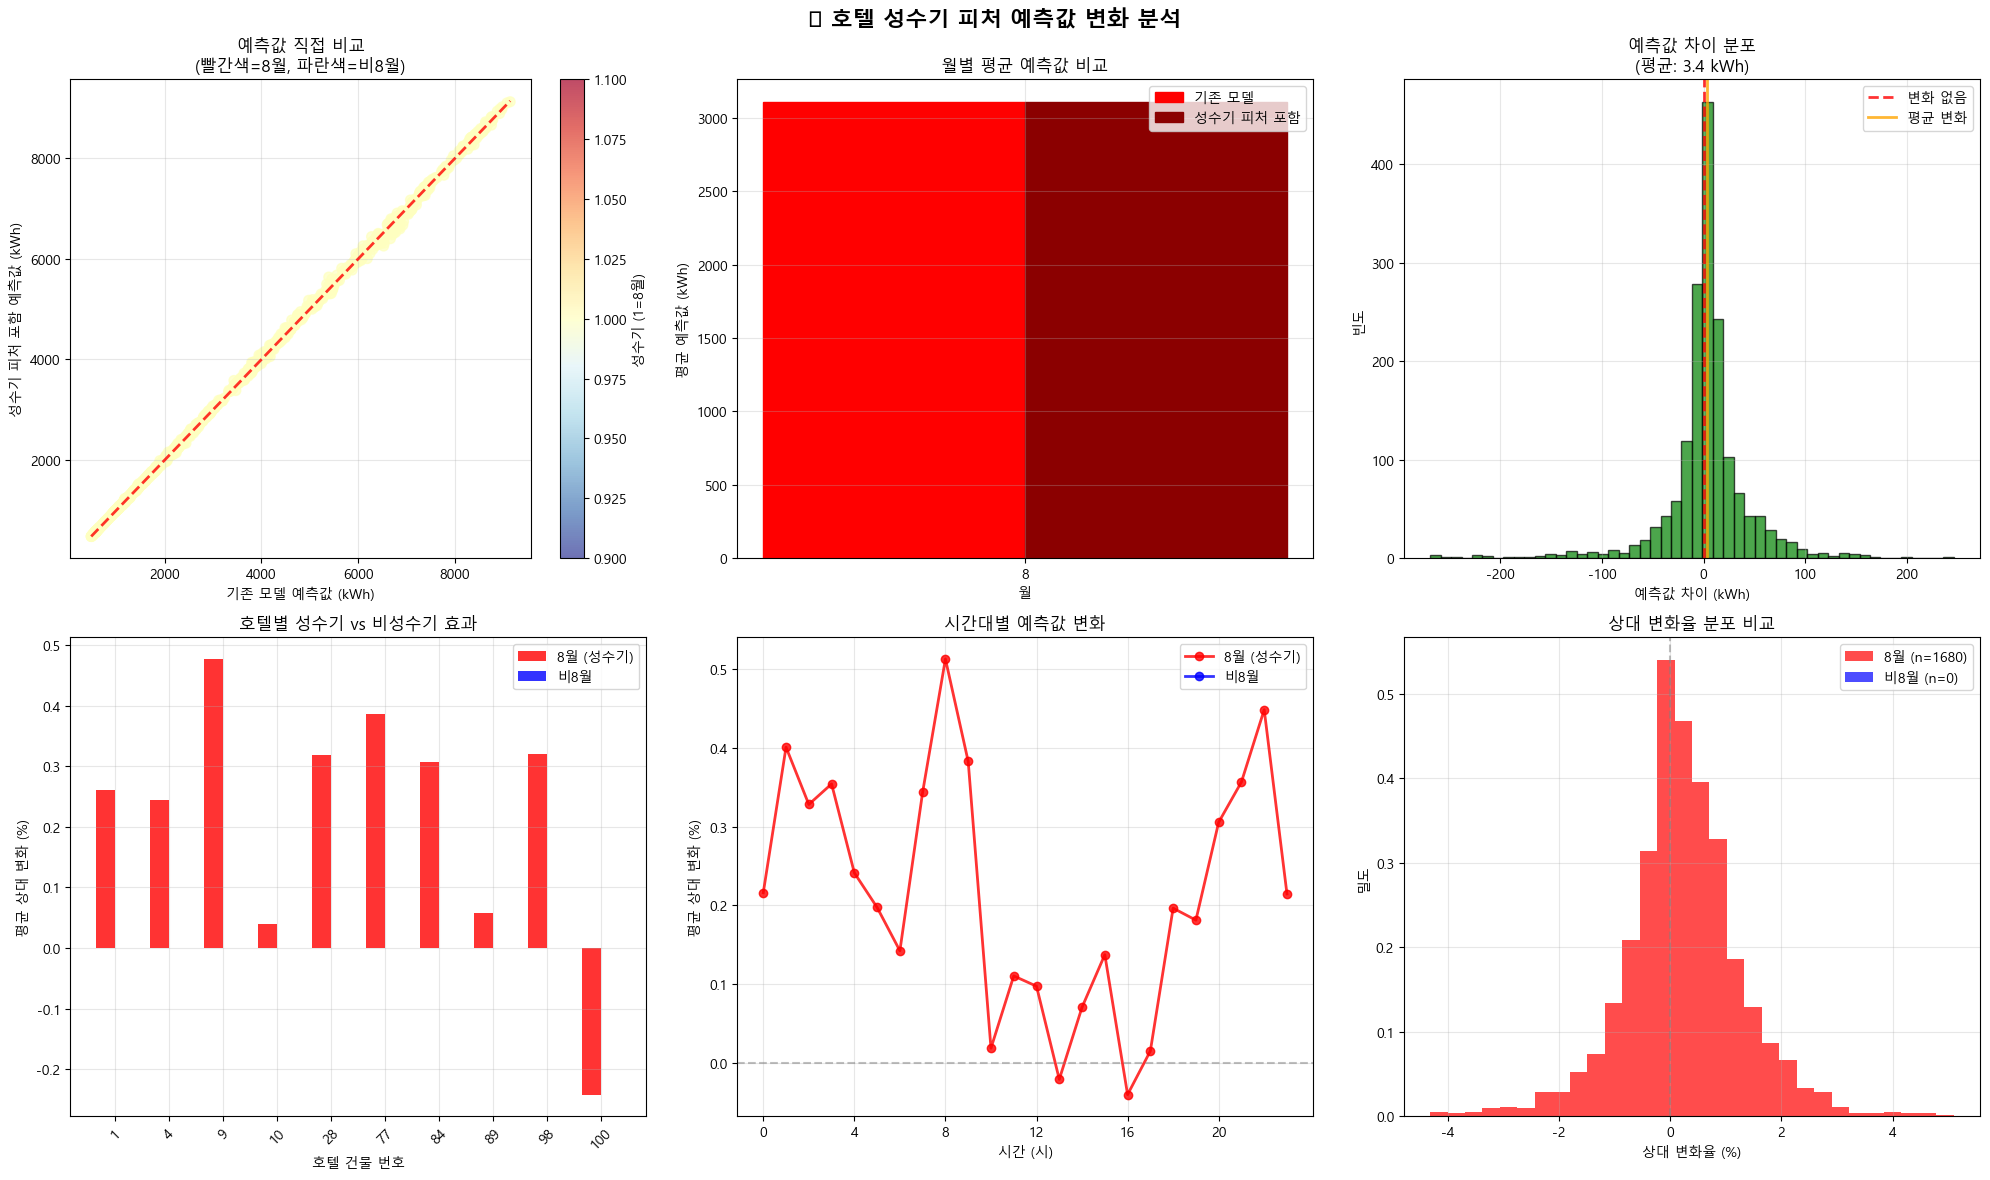


🔍 상세 변화 분석:

📈 예측값 증가가 큰 호텔 TOP 3:
   1. 건물 9: +0.48%
   2. 건물 77: +0.39%
   3. 건물 98: +0.32%

📉 예측값 감소가 큰 호텔 TOP 3:
   1. 건물 89: +0.06%
   2. 건물 10: +0.04%
   3. 건물 100: -0.24%

🌟 성수기 효과가 가장 뚜렷한 호텔 TOP 3:

📊 전체 변화 요약:
   전체 평균 변화: +0.22%
   8월 평균 변화: +0.22%
   비8월 평균 변화: +nan%
   성수기 효과 차이: +nan%

⚠️ 성수기 피처 효과가 예상과 다릅니다.

✅ 호텔 성수기 피처 예측값 변화 분석 완료


In [21]:
# 한글 폰트 설정 (Windows 기준)""
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 호텔 성수기 피처 효과 시각화 분석
print("🔍 호텔 성수기 피처 예측값 변화 시각화")
print("=" * 60)

# 1. 기존 결과에서 호텔 예측값 추출
print("📊 기존 결과와 성수기 피처 포함 결과 비교 준비 중...")

# 기존 앙상블 결과 로드
existing_submission = pd.read_csv('result_csv/ensemble_submission.csv')
print(f"✅ 기존 제출 파일 로드: {existing_submission.shape}")

# 호텔 건물 번호
hotel_buildings = building_info[building_info['building_type'] == 'Hotel']['building_number'].tolist()
print(f"🏨 호텔 건물 번호: {sorted(hotel_buildings)}")

# 호텔 테스트 데이터 인덱스
hotel_test_mask = test_X['building_number'].isin(hotel_buildings)
hotel_test_indices = test_X[hotel_test_mask].index

print(f"📍 호텔 테스트 데이터 인덱스: {len(hotel_test_indices)}개")

# 기존 결과에서 호텔 예측값 추출
existing_hotel_predictions = existing_submission.loc[hotel_test_indices, 'answer'].values

# 성수기 피처 포함한 새로운 예측값 (앞서 계산된 앙상블 결과)
new_hotel_predictions = ensemble_predictions_dept.values

print(f"✅ 예측값 추출 완료:")
print(f"   기존 예측값: {len(existing_hotel_predictions)}개")
print(f"   새 예측값: {len(new_hotel_predictions)}개")

# 2. 호텔 테스트 데이터 정보 추출
hotel_test_data = test[test['building_number'].isin(hotel_buildings)].copy()
hotel_test_data = hotel_test_data.reset_index(drop=True)

# 3. 예측값 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'building_number': hotel_test_data['building_number'],
    'date_time': hotel_test_data['date_time'],
    'month': hotel_test_data['month'],
    'hour': hotel_test_data['hour'],
    'peak_season': hotel_test_data['peak_season'] if 'peak_season' in hotel_test_data.columns else 0,
    'pred_existing': existing_hotel_predictions,
    'pred_with_peak': new_hotel_predictions,
    'difference': new_hotel_predictions - existing_hotel_predictions,
    'relative_change': ((new_hotel_predictions - existing_hotel_predictions) / existing_hotel_predictions) * 100
})

# 4. 통계 요약
print(f"\n📈 예측값 변화 통계:")
print(f"   평균 절대 차이: {np.mean(np.abs(comparison_df['difference'])):.2f} kWh")
print(f"   평균 상대 변화: {np.mean(comparison_df['relative_change']):.2f}%")
print(f"   최대 증가: {comparison_df['difference'].max():.2f} kWh")
print(f"   최대 감소: {comparison_df['difference'].min():.2f} kWh")

# 8월(성수기)과 비성수기 구분 분석
august_mask = comparison_df['month'] == 8
non_august_mask = comparison_df['month'] != 8

print(f"\n🏨 월별 변화:")
print(f"   8월(성수기) 평균 변화: {comparison_df[august_mask]['relative_change'].mean():.2f}%")
print(f"   비성수기 평균 변화: {comparison_df[non_august_mask]['relative_change'].mean():.2f}%")
print(f"   8월 데이터 포인트: {len(comparison_df[august_mask])}개")
print(f"   비8월 데이터 포인트: {len(comparison_df[non_august_mask])}개")

# 5. 시각화
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('🏨 호텔 성수기 피처 예측값 변화 분석', fontsize=16, fontweight='bold')

# 1. 전체 예측값 비교 (산점도)
scatter = axes[0, 0].scatter(comparison_df['pred_existing'], comparison_df['pred_with_peak'], 
                            alpha=0.7, c=comparison_df['peak_season'], cmap='RdYlBu_r', s=50)
axes[0, 0].plot([comparison_df['pred_existing'].min(), comparison_df['pred_existing'].max()],
                [comparison_df['pred_existing'].min(), comparison_df['pred_existing'].max()], 
                'r--', alpha=0.8, linewidth=2)
axes[0, 0].set_xlabel('기존 모델 예측값 (kWh)')
axes[0, 0].set_ylabel('성수기 피처 포함 예측값 (kWh)')
axes[0, 0].set_title('예측값 직접 비교\n(빨간색=8월, 파란색=비8월)')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='성수기 (1=8월)')

# 2. 월별 평균 예측값 변화
monthly_comparison = comparison_df.groupby('month').agg({
    'pred_existing': 'mean',
    'pred_with_peak': 'mean',
    'difference': 'mean',
    'relative_change': 'mean'
}).reset_index()

x_pos = np.arange(len(monthly_comparison))
width = 0.35

bars1 = axes[0, 1].bar(x_pos - width/2, monthly_comparison['pred_existing'], width, 
                       label='기존 모델', alpha=0.8, color='skyblue')
bars2 = axes[0, 1].bar(x_pos + width/2, monthly_comparison['pred_with_peak'], width, 
                       label='성수기 피처 포함', alpha=0.8, color='orange')

# 8월 강조
august_idx = monthly_comparison[monthly_comparison['month'] == 8].index
if len(august_idx) > 0:
    idx = august_idx[0]
    bars1[idx].set_color('red')
    bars1[idx].set_alpha(1.0)
    bars2[idx].set_color('darkred')
    bars2[idx].set_alpha(1.0)

axes[0, 1].set_xlabel('월')
axes[0, 1].set_ylabel('평균 예측값 (kWh)')
axes[0, 1].set_title('월별 평균 예측값 비교')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(monthly_comparison['month'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 예측값 차이 분포
axes[0, 2].hist(comparison_df['difference'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 2].axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2, label='변화 없음')
axes[0, 2].axvline(x=comparison_df['difference'].mean(), color='orange', linestyle='-', alpha=0.8, linewidth=2, label=f'평균 변화')
axes[0, 2].set_xlabel('예측값 차이 (kWh)')
axes[0, 2].set_ylabel('빈도')
axes[0, 2].set_title(f'예측값 차이 분포\n(평균: {comparison_df["difference"].mean():.1f} kWh)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. 호텔별 8월 vs 비8월 평균 변화
hotel_nums = sorted(hotel_buildings)
hotel_august_effects = []
hotel_non_august_effects = []

for hotel_num in hotel_nums:
    aug_effect = comparison_df[(comparison_df['building_number'] == hotel_num) & 
                              (comparison_df['peak_season'] == 1)]['relative_change'].mean()
    non_aug_effect = comparison_df[(comparison_df['building_number'] == hotel_num) & 
                                  (comparison_df['peak_season'] == 0)]['relative_change'].mean()
    
    hotel_august_effects.append(aug_effect if not np.isnan(aug_effect) else 0)
    hotel_non_august_effects.append(non_aug_effect if not np.isnan(non_aug_effect) else 0)

x_pos = np.arange(len(hotel_nums))
width = 0.35

axes[1, 0].bar(x_pos - width/2, hotel_august_effects, width, 
               label='8월 (성수기)', alpha=0.8, color='red')
axes[1, 0].bar(x_pos + width/2, hotel_non_august_effects, width, 
               label='비8월', alpha=0.8, color='blue')
axes[1, 0].set_xlabel('호텔 건물 번호')
axes[1, 0].set_ylabel('평균 상대 변화 (%)')
axes[1, 0].set_title('호텔별 성수기 vs 비성수기 효과')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(hotel_nums, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 시간대별 예측값 변화 (8월 vs 비8월)
hourly_august = comparison_df[comparison_df['peak_season'] == 1].groupby('hour')['relative_change'].mean()
hourly_non_august = comparison_df[comparison_df['peak_season'] == 0].groupby('hour')['relative_change'].mean()

axes[1, 1].plot(hourly_august.index, hourly_august.values, 'ro-', label='8월 (성수기)', alpha=0.8, linewidth=2)
axes[1, 1].plot(hourly_non_august.index, hourly_non_august.values, 'bo-', label='비8월', alpha=0.8, linewidth=2)
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('시간 (시)')
axes[1, 1].set_ylabel('평균 상대 변화 (%)')
axes[1, 1].set_title('시간대별 예측값 변화')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 4))

# 6. 상대 변화율 분포 (8월 vs 비8월)
axes[1, 2].hist(comparison_df[august_mask]['relative_change'], bins=30, alpha=0.7, 
                color='red', label=f'8월 (n={len(comparison_df[august_mask])})', density=True)
axes[1, 2].hist(comparison_df[non_august_mask]['relative_change'], bins=30, alpha=0.7, 
                color='blue', label=f'비8월 (n={len(comparison_df[non_august_mask])})', density=True)
axes[1, 2].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 2].set_xlabel('상대 변화율 (%)')
axes[1, 2].set_ylabel('밀도')
axes[1, 2].set_title('상대 변화율 분포 비교')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 상세 분석 결과 출력
print("\n🔍 상세 변화 분석:")
print("=" * 50)

# 가장 큰 변화를 보인 호텔들
hotel_avg_changes = comparison_df.groupby('building_number')['relative_change'].mean().sort_values(ascending=False)
print(f"\n📈 예측값 증가가 큰 호텔 TOP 3:")
for i, (building, change) in enumerate(hotel_avg_changes.head(3).items()):
    print(f"   {i+1}. 건물 {building}: {change:+.2f}%")

print(f"\n📉 예측값 감소가 큰 호텔 TOP 3:")
for i, (building, change) in enumerate(hotel_avg_changes.tail(3).items()):
    print(f"   {i+1}. 건물 {building}: {change:+.2f}%")

# 8월과 다른 월의 효과 차이가 큰 호텔
hotel_seasonal_effect = []
for hotel_num in hotel_nums:
    hotel_data = comparison_df[comparison_df['building_number'] == hotel_num]
    aug_effect = hotel_data[hotel_data['peak_season'] == 1]['relative_change'].mean()
    non_aug_effect = hotel_data[hotel_data['peak_season'] == 0]['relative_change'].mean()
    
    if not np.isnan(aug_effect) and not np.isnan(non_aug_effect):
        seasonal_diff = aug_effect - non_aug_effect
        hotel_seasonal_effect.append((hotel_num, seasonal_diff, aug_effect, non_aug_effect))

hotel_seasonal_effect.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\n🌟 성수기 효과가 가장 뚜렷한 호텔 TOP 3:")
for i, (building, diff, aug_eff, non_aug_eff) in enumerate(hotel_seasonal_effect[:3]):
    print(f"   {i+1}. 건물 {building}: 8월 {aug_eff:+.2f}% vs 비8월 {non_aug_eff:+.2f}% (차이: {diff:+.2f}%)")

# 전체 효과 요약
total_change = comparison_df['relative_change'].mean()
august_change = comparison_df[august_mask]['relative_change'].mean()
non_august_change = comparison_df[non_august_mask]['relative_change'].mean()

print(f"\n📊 전체 변화 요약:")
print(f"   전체 평균 변화: {total_change:+.2f}%")
print(f"   8월 평균 변화: {august_change:+.2f}%")
print(f"   비8월 평균 변화: {non_august_change:+.2f}%")
print(f"   성수기 효과 차이: {august_change - non_august_change:+.2f}%")

# 결론
if august_change > non_august_change:
    print(f"\n✅ 성수기 피처가 8월에 더 큰 변화를 보입니다!")
    print(f"   8월이 비8월보다 {august_change - non_august_change:.2f}% 더 변화함")
else:
    print(f"\n⚠️ 성수기 피처 효과가 예상과 다릅니다.")

print("\n✅ 호텔 성수기 피처 예측값 변화 분석 완료")

In [22]:
print("📝 최종 제출 파일 생성 중...")

# 음수값 처리 (전력 소비량은 음수가 될 수 없음)
final_submission["answer"] = np.maximum(final_submission["answer"], 0)

# 최종 제출 파일 저장
final_submission.to_csv('result_csv/Hotel_성수기추가.csv', index=False)

print("✅ 최종 제출 파일 저장: result_csv/Hotel_성수기추가.csv")




📝 최종 제출 파일 생성 중...
✅ 최종 제출 파일 저장: result_csv/Hotel_성수기추가.csv
